In [190]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import torch.nn as nn
import torch.optim as optim
import torchvision.models

# Подготовка и анализ данных 

Загрузка данных

In [17]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [18]:
X = train_df.drop('label', axis=1).values
y = train_df['label'].values
X_submission = test_df.values

In [19]:
y

array([1, 0, 1, ..., 7, 6, 9], dtype=int64)

Решейп данных в формат изображений (количество, высота, ширина)

In [ ]:
X = X.reshape(-1, 28, 28)
X_submission = X_submission.reshape(-1, 28, 28)

Разделим исходный обучающий набор данных на две части:

- Тренировочная выборка (80%): для обучения моделей.

- Валидационная (тестовая) выборка (20%): для оценки качества моделей на данных, которые они не видели в процессе обучения.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Отобразим 10 примеров из нашего датасета

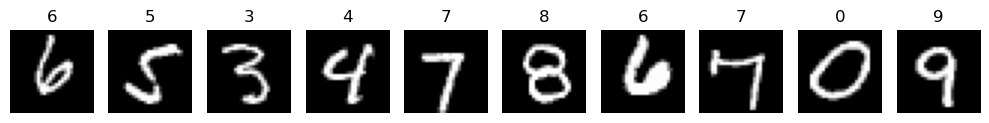

In [22]:
def show_images(images, labels, n=10):
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"{labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images(X_train, y_train)

Анализ распределения классов

<Axes: title={'center': 'Распределение тергета'}>

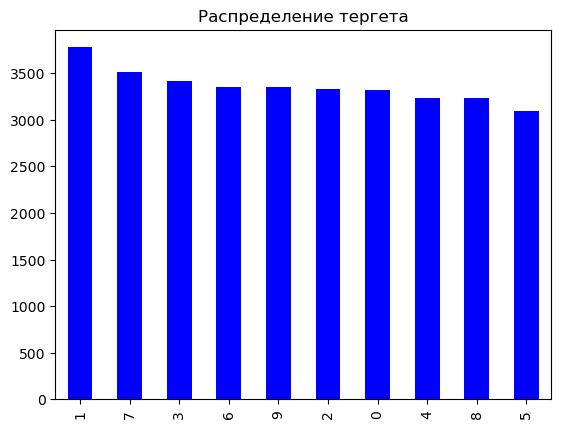

In [23]:
pd.Series(y_train).value_counts().plot(kind='bar', colormap='winter', title = 'Распределение тергета')

In [ ]:
# Нормализация данных
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) / 255.0
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1) / 255.0
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_submission_tensor = torch.tensor(X_submission, dtype=torch.float32).unsqueeze(1) / 255.0

# Создание DataLoader'ов для PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
submission_dataset = TensorDataset(X_submission_tensor)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
submission_loader = DataLoader(submission_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Для классических моделей ML "развернем" данные обратно
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.0
X_submission_flat = X_submission.reshape(X_submission.shape[0], -1) / 255.0

# Метрики

Для оценки качества классических моделей машинного обучения в задаче распознавания рукописных цифр выбраны следующие метрики:

Accuracy — доля правильно классифицированных изображений.

Precision, Recall, F1-score — для анализа точности и полноты классификации каждого класса и их гармонического среднего.

Обоснование:

Датасет MNIST относительно сбалансирован, поэтому accuracy показывает общую эффективность модели. Также данная метрика используется, как основная, для оценки в данном соревновании.

Дополнительные метрики позволяют оценить работу модели по каждому классу и выявить возможные ошибки.

Этот набор метрик достаточен для сравнения классических алгоритмов и выбора лучших для дальнейшего обучения.

# Классические модели

## Обучение моделей

### Логистическая регрессия

In [25]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_flat, y_train)
y_pred_logreg = logreg.predict(X_test_flat)

print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Precision (macro):", precision_score(y_test, y_pred_logreg, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_logreg, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_logreg, average='macro'))

Accuracy: 0.919047619047619
Precision (macro): 0.9178980096647361
Recall (macro): 0.9188442107119524
F1-score (macro): 0.9182606844798841


In [26]:
predictions_logreg = logreg.predict(X_submission_flat)

In [27]:
# Создание submission.csv
submission_df_logreg = pd.DataFrame({'ImageId': range(1, len(predictions_logreg) + 1), 'Label': predictions_logreg})
submission_df_logreg.to_csv('submission_logreg.csv', index=False)

### Метод опорных векторов

In [28]:
svm = SVC(kernel='rbf')
svm.fit(X_train_flat, y_train)
y_pred_svm = svm.predict(X_test_flat)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision (macro):", precision_score(y_test, y_pred_svm, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_svm, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_svm, average='macro'))

Accuracy: 0.973452380952381
Precision (macro): 0.973416373747596
Recall (macro): 0.9735339772335252
F1-score (macro): 0.9734602615363981


In [29]:
predictions_svm = svm.predict(X_submission_flat)

In [30]:
# Создание submission.csv
submission_df_svm = pd.DataFrame({'ImageId': range(1, len(predictions_svm) + 1), 'Label': predictions_svm})
submission_df_svm.to_csv('submission_svm.csv', index=False)

### Метод K-ближайших соседей

In [32]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_flat, y_train)
y_pred_knn = knn.predict(X_test_flat)

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision (macro):", precision_score(y_test, y_pred_knn, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_knn, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_knn, average='macro'))

Accuracy: 0.9648809523809524
Precision (macro): 0.9656422580407042
Recall (macro): 0.9647514944838347
F1-score (macro): 0.9649291494053396


In [33]:
predictions_knn = knn.predict(X_submission_flat)

In [34]:
# Создание submission.csv
submission_df_knn = pd.DataFrame({'ImageId': range(1, len(predictions_knn) + 1), 'Label': predictions_knn})
submission_df_knn.to_csv('submission_knn.csv', index=False)

### Случайный лес

In [35]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_flat, y_train)
y_pred_rf = rf.predict(X_test_flat)

print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision (macro):", precision_score(y_test, y_pred_rf, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_rf, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_rf, average='macro'))

Random Forest:
Accuracy: 0.9629761904761904
Precision (macro): 0.9628494321468949
Recall (macro): 0.9630201177608895
F1-score (macro): 0.9629039101845235


In [36]:
predictions_rf = rf.predict(X_submission_flat)

In [37]:
# Создание submission.csv
submission_df_rf = pd.DataFrame({'ImageId': range(1, len(predictions_rf) + 1), 'Label': predictions_rf})
submission_df_rf.to_csv('submission_rf.csv', index=False)

### Градиентный бустинг (CatBoost)

In [38]:
cat = CatBoostClassifier(verbose=0, random_state=42, task_type = 'GPU')
cat.fit(X_train_flat, y_train)
y_pred_cat = cat.predict(X_test_flat)

print("CatBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("Precision (macro):", precision_score(y_test, y_pred_cat, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_cat, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_cat, average='macro'))

CatBoost:
Accuracy: 0.9721428571428572
Precision (macro): 0.9721402271079741
Recall (macro): 0.9719893813177507
F1-score (macro): 0.9720435316687424


In [39]:
predictions_cat = cat.predict(X_submission_flat)
predictions_cat = predictions_cat.ravel()

In [40]:
# Создание submission.csv
submission_df_cat = pd.DataFrame({'ImageId': range(1, len(predictions_cat) + 1), 'Label': predictions_cat})
submission_df_cat.to_csv('submission_cat.csv', index=False)

## Подбор гиперпараметров 

In [41]:
param_grid_logreg = {
    "C": [0.01, 0.1, 1],
    "solver": ["lbfgs", "saga"]
}

grid_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=3, scoring='accuracy',  verbose=2)
grid_logreg.fit(X_train_flat, y_train)
best_logreg = grid_logreg.best_estimator_

y_pred_logreg_best = best_logreg.predict(X_test_flat)

print("Логистическая регрессия:")
print("Лучшие параметры:", grid_logreg.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_logreg_best))
print("Precision (macro):", precision_score(y_test, y_pred_logreg_best, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_logreg_best, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_logreg_best, average='macro'))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...............................C=0.01, solver=lbfgs; total time=   2.1s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   1.9s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   1.9s
[CV] END ................................C=0.01, solver=saga; total time=  30.6s
[CV] END ................................C=0.01, solver=saga; total time=  25.9s
[CV] END ................................C=0.01, solver=saga; total time=  31.6s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.1s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.1s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.2s
[CV] END .................................C=0.1, solver=saga; total time=  47.4s
[CV] END .................................C=0.1, solver=saga; total time=  41.3s
[CV] END .................................C=0.1, 

In [42]:
param_grid_svm = {
    "C": [0.1, 1, 10]
}

grid_svm = GridSearchCV(SVC(kernel="rbf"), param_grid_svm, cv=3, scoring='accuracy', verbose=2)
grid_svm.fit(X_train_flat, y_train)
best_svm = grid_svm.best_estimator_

y_pred_svm_best = best_svm.predict(X_test_flat)

print("Метод опорных векторов:")
print("Лучшие параметры:", grid_svm.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_svm_best))
print("Precision (macro):", precision_score(y_test, y_pred_svm_best, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_svm_best, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_svm_best, average='macro'))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..............................................C=0.1; total time= 1.2min
[CV] END ..............................................C=0.1; total time= 1.2min
[CV] END ..............................................C=0.1; total time= 1.2min
[CV] END ................................................C=1; total time=  34.5s
[CV] END ................................................C=1; total time=  33.4s
[CV] END ................................................C=1; total time=  32.8s
[CV] END ...............................................C=10; total time=  32.8s
[CV] END ...............................................C=10; total time=  31.5s
[CV] END ...............................................C=10; total time=  31.5s
Метод опорных векторов:
Лучшие параметры: {'C': 10}
Accuracy: 0.9798809523809524
Precision (macro): 0.9797949861553269
Recall (macro): 0.9797421249474197
F1-score (macro): 0.9797576658598885


In [43]:
param_grid_knn = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"]
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='accuracy', verbose=2)
grid_knn.fit(X_train_flat, y_train)
best_knn = grid_knn.best_estimator_

y_pred_knn_best = best_knn.predict(X_test_flat)

print("Метод K-ближайших соседей:")
print("Лучшие параметры:", grid_knn.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_knn_best))
print("Precision (macro):", precision_score(y_test, y_pred_knn_best, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_knn_best, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_knn_best, average='macro'))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=   1.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   1.0s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   1.0s
[CV] END ....................n_neighbors=3, weights=distance; total time=   1.0s
[CV] END ....................n_neighbors=3, weights=distance; total time=   1.0s
[CV] END ....................n_neighbors=3, weights=distance; total time=   1.0s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   1.0s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   1.1s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   1.2s
[CV] END ....................n_neighbors=5, weights=distance; total time=   1.1s
[CV] END ....................n_neighbors=5, weights=distance; total time=   1.1s
[CV] END ....................n_neighbors=5, weigh

In [44]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', verbose=2)
grid_rf.fit(X_train_flat, y_train)
best_rf = grid_rf.best_estimator_

y_pred_rf_best = best_rf.predict(X_test_flat)

print("Случайный лес:")
print("Лучшие параметры:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf_best))
print("Precision (macro):", precision_score(y_test, y_pred_rf_best, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_rf_best, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_rf_best, average='macro'))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   7.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   7.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  15.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  15.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  15.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   7.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   7.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   7.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=  14.8s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=  14.8s
[CV] END max_depth=None, m

In [45]:
param_grid_cat = {
    "iterations": [200, 400],
    "depth": [4, 6],
    "learning_rate": [0.1, 0.2],
    "l2_leaf_reg": [3, 5]
}


grid_cat = GridSearchCV(CatBoostClassifier(random_state=42, task_type='GPU', verbose = 0), param_grid_cat, cv=3, scoring='accuracy', verbose=2)
grid_cat.fit(X_train_flat, y_train)
best_cat = grid_cat.best_estimator_

y_pred_cat_best = best_cat.predict(X_test_flat)

print("Градиентный бустинг (CatBoost):")
print("Лучшие параметры:", grid_cat.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_cat_best))
print("Precision (macro):", precision_score(y_test, y_pred_cat_best, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_cat_best, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred_cat_best, average='macro'))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   6.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   6.6s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   6.9s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.2; total time=   6.4s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.2; total time=   6.4s
[CV] END depth=4, iterations=200, l2_leaf_reg=3, learning_rate=0.2; total time=   6.4s
[CV] END depth=4, iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   6.6s
[CV] END depth=4, iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   7.0s
[CV] END depth=4, iterations=200, l2_leaf_reg=5, learning_rate=0.1; total time=   6.8s
[CV] END depth=4, iterations=200, l2_leaf_reg=5, learning_rate=0.2; total time=   6.6s
[CV] END depth=4, iterations=200, l2_leaf_reg=5, learning_rate=0.2; t

In [ ]:
# logreg
predictions_logreg_best = best_logreg.predict(X_submission_flat)

submission_df_logreg_best = pd.DataFrame({'ImageId': range(1, len(predictions_logreg_best) + 1), 'Label': predictions_logreg_best})
submission_df_logreg_best.to_csv('submission_logreg_best.csv', index=False)
# svm
predictions_svm_best = best_svm.predict(X_submission_flat)

submission_df_svm_best = pd.DataFrame({'ImageId': range(1, len(predictions_svm_best) + 1), 'Label': predictions_svm_best})
submission_df_svm_best.to_csv('submission_svm_best.csv', index=False)
# knn
predictions_knn_best = best_knn.predict(X_submission_flat)

submission_df_knn_best = pd.DataFrame({'ImageId': range(1, len(predictions_knn_best) + 1), 'Label': predictions_knn_best})
submission_df_knn_best.to_csv('submission_knn_best.csv', index=False)
# rf
predictions_rf_best = best_rf.predict(X_submission_flat)

submission_df_rf_best = pd.DataFrame({'ImageId': range(1, len(predictions_rf_best) + 1), 'Label': predictions_rf_best})
submission_df_rf_best.to_csv('submission_rf_best.csv', index=False)
# catboost
predictions_cat_best = best_cat.predict(X_submission_flat)
predictions_cat_best = predictions_cat_best.ravel()

submission_df_cat_best = pd.DataFrame({'ImageId': range(1, len(predictions_cat_best) + 1), 'Label': predictions_cat_best})
submission_df_cat_best.to_csv('submission_cat_best.csv', index=False)

## Сравнение результатов классических моделей

In [47]:
models = ["LogReg", "SVM", "kNN", "RandomForest", "CatBoost"]
y_preds_base = [y_pred_logreg, y_pred_svm, y_pred_knn, y_pred_rf, y_pred_cat]
y_preds_best = [y_pred_logreg_best, y_pred_svm_best, y_pred_knn_best, y_pred_rf_best, y_pred_cat_best]

data = []
for model, yb, ybest in zip(models, y_preds_base, y_preds_best):
    row = {
        "Model": model,
        "Accuracy (base)": accuracy_score(y_test, yb),
        "Precision (base)": precision_score(y_test, yb, average='macro'),
        "Recall (base)": recall_score(y_test, yb, average='macro'),
        "F1 (base)": f1_score(y_test, yb, average='macro'),
        "Accuracy (best)": accuracy_score(y_test, ybest),
        "Precision (best)": precision_score(y_test, ybest, average='macro'),
        "Recall (best)": recall_score(y_test, ybest, average='macro'),
        "F1 (best)": f1_score(y_test, ybest, average='macro'),
    }
    data.append(row)

df_metrics = pd.DataFrame(data)
df_metrics

,Model,Accuracy (base),Precision (base),Recall (base),F1 (base),Accuracy (best),Precision (best),Recall (best),F1 (best)
0,LogReg,0.919048,0.917898,0.918844,0.918261,0.920119,0.918986,0.919634,0.919226
1,SVM,0.973452,0.973416,0.973534,0.973460,0.979881,0.979795,0.979742,0.979758
2,kNN,0.964881,0.965642,0.964751,0.964929,0.968333,0.968560,0.968388,0.968306
3,RandomForest,0.962976,0.962849,0.963020,0.962904,0.963571,0.963514,0.963709,0.963583
4,CatBoost,0.972143,0.972140,0.971989,0.972044,0.965357,0.965354,0.965117,0.965213


# Нейросетевые модели 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) 

cuda


## Обучение моделей

### MLP

In [309]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [310]:
model_mlp = MLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)
EPOCHS = 10

In [311]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model_mlp.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_mlp(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    test_loss = 0.0
    model_mlp.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_mlp(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    print(f"Эпоха [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss} | Test Loss: {test_loss}")


Эпоха [1/10] | Train Loss: 0.4450679142098916 | Test Loss: 0.2568164316542221
Эпоха [2/10] | Train Loss: 0.17927589717926634 | Test Loss: 0.15714605276783308
Эпоха [3/10] | Train Loss: 0.12392736077591947 | Test Loss: 0.1321251807226376
Эпоха [4/10] | Train Loss: 0.09187136960885144 | Test Loss: 0.1279086678599318
Эпоха [5/10] | Train Loss: 0.06933669562844609 | Test Loss: 0.10419236253382581
Эпоха [6/10] | Train Loss: 0.05224013903635083 | Test Loss: 0.09631095571217663
Эпоха [7/10] | Train Loss: 0.04266383006510116 | Test Loss: 0.0945616818004937
Эпоха [8/10] | Train Loss: 0.0330626237323019 | Test Loss: 0.09910641198582722
Эпоха [9/10] | Train Loss: 0.022540709618195723 | Test Loss: 0.09972925295093746
Эпоха [10/10] | Train Loss: 0.018444564494927602 | Test Loss: 0.0937093083295181


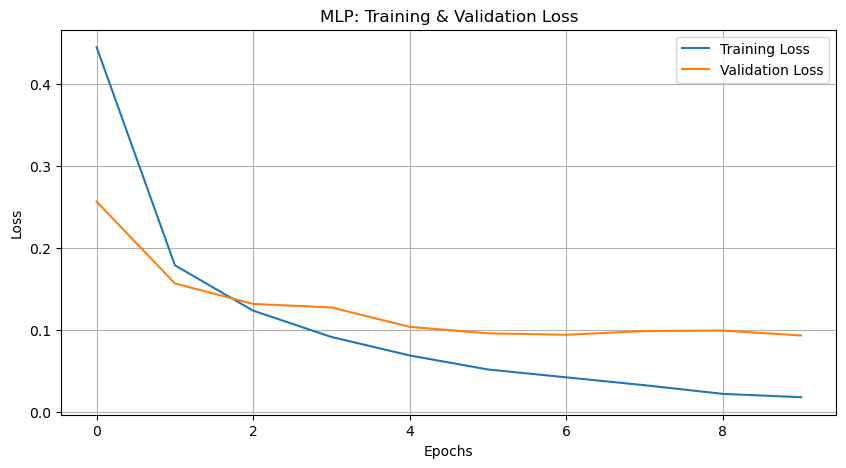

In [312]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('MLP: Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [313]:
model_mlp.eval()
y_true, y_pred_mlp = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_mlp(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred_mlp.extend(preds.cpu().numpy())

print("MLP")
print("Accuracy:", accuracy_score(y_true, y_pred_mlp))
print("Precision (macro):", precision_score(y_true, y_pred_mlp, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred_mlp, average='macro'))
print("F1-score (macro):", f1_score(y_true, y_pred_mlp, average='macro'))

MLP
Accuracy: 0.9744047619047619
Precision (macro): 0.9742341127501138
Recall (macro): 0.9742560963555412
F1-score (macro): 0.97417816916156


### CNN

In [319]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [320]:
model_cnn = CNN().to(device)

optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
EPOCHS = 50

In [321]:
train_losses_cnn = []
test_losses_cnn = []

for epoch in range(EPOCHS):
    model_cnn.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses_cnn.append(train_loss)

    test_loss = 0.0
    model_cnn.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_cnn(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    test_losses_cnn.append(test_loss)

    print(f"Эпоха [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss} | Test Loss: {test_loss}")


Эпоха [1/50] | Train Loss: 0.364981275165149 | Test Loss: 0.12343646704473278
Эпоха [2/50] | Train Loss: 0.08213867672042702 | Test Loss: 0.07170881610363722
Эпоха [3/50] | Train Loss: 0.05606656918875845 | Test Loss: 0.05726860314043182
Эпоха [4/50] | Train Loss: 0.04429541728122889 | Test Loss: 0.050760793894755116
Эпоха [5/50] | Train Loss: 0.03486042692035635 | Test Loss: 0.04587811733257364
Эпоха [6/50] | Train Loss: 0.026910058512200137 | Test Loss: 0.04692255669259325
Эпоха [7/50] | Train Loss: 0.021975821064264572 | Test Loss: 0.04542331185163648
Эпоха [8/50] | Train Loss: 0.019879457273010603 | Test Loss: 0.04441596674344813
Эпоха [9/50] | Train Loss: 0.01540853041348122 | Test Loss: 0.05726734685683341
Эпоха [10/50] | Train Loss: 0.014643042415164467 | Test Loss: 0.05052616329383895
Эпоха [11/50] | Train Loss: 0.011867857035320294 | Test Loss: 0.04623361939395016
Эпоха [12/50] | Train Loss: 0.01036433907812895 | Test Loss: 0.043253739678413804
Эпоха [13/50] | Train Loss: 0.00

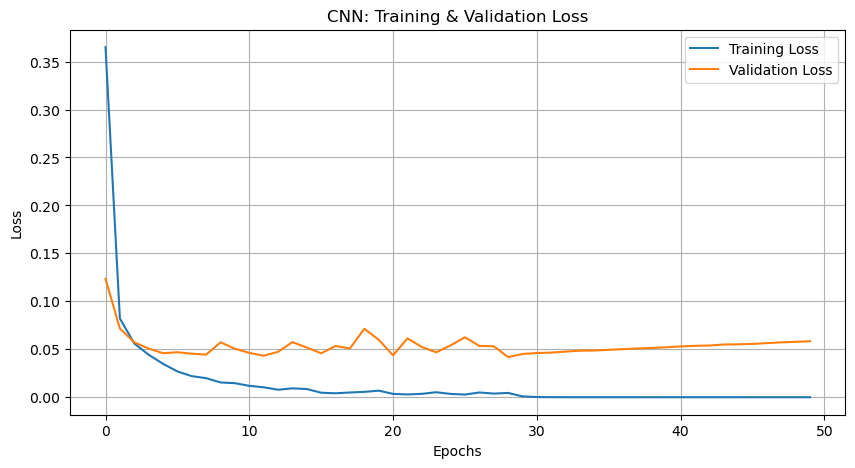

In [322]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_cnn, label='Training Loss')
plt.plot(test_losses_cnn, label='Validation Loss')
plt.title('CNN: Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [323]:
model_cnn.eval()
y_true, y_pred_cnn = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred_cnn.extend(preds.cpu().numpy())

print("CNN")
print("Accuracy:", accuracy_score(y_true, y_pred_cnn))
print("Precision (macro):", precision_score(y_true, y_pred_cnn, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred_cnn, average='macro'))
print("F1-score (macro):", f1_score(y_true, y_pred_cnn, average='macro'))

CNN
Accuracy: 0.991547619047619
Precision (macro): 0.9914199084636337
Recall (macro): 0.9914554449524063
F1-score (macro): 0.9914330978561583


### ResNet50

In [324]:
class ResNetMNIST(nn.Module):
    def __init__(self):
        super(ResNetMNIST, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

In [325]:
model_resnet = ResNetMNIST().to(device)

optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
EPOCHS = 10

d:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [326]:
train_losses_resnet = []
test_losses_resnet = []

for epoch in range(EPOCHS):
    model_resnet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses_resnet.append(train_loss)

    test_loss = 0.0
    model_resnet.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    test_losses_resnet.append(test_loss)

    print(f"Эпоха [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss} | Test Loss: {test_loss}")


Эпоха [1/10] | Train Loss: 0.389711058496749 | Test Loss: 0.13093338997075052
Эпоха [2/10] | Train Loss: 0.08691060612466853 | Test Loss: 0.09585332248190587
Эпоха [3/10] | Train Loss: 0.051356622222421454 | Test Loss: 0.09108012776370301
Эпоха [4/10] | Train Loss: 0.041553058544219874 | Test Loss: 0.10261206760663878
Эпоха [5/10] | Train Loss: 0.05088165715804231 | Test Loss: 0.11338770334524187
Эпоха [6/10] | Train Loss: 0.05986785247369524 | Test Loss: 0.07677427213639021
Эпоха [7/10] | Train Loss: 0.03911905526670454 | Test Loss: 0.07294124388841516
Эпоха [8/10] | Train Loss: 0.020187995129197608 | Test Loss: 0.06896237764070093
Эпоха [9/10] | Train Loss: 0.02106448165963257 | Test Loss: 0.06764162535281767
Эпоха [10/10] | Train Loss: 0.018012618498127294 | Test Loss: 0.0597529531470641


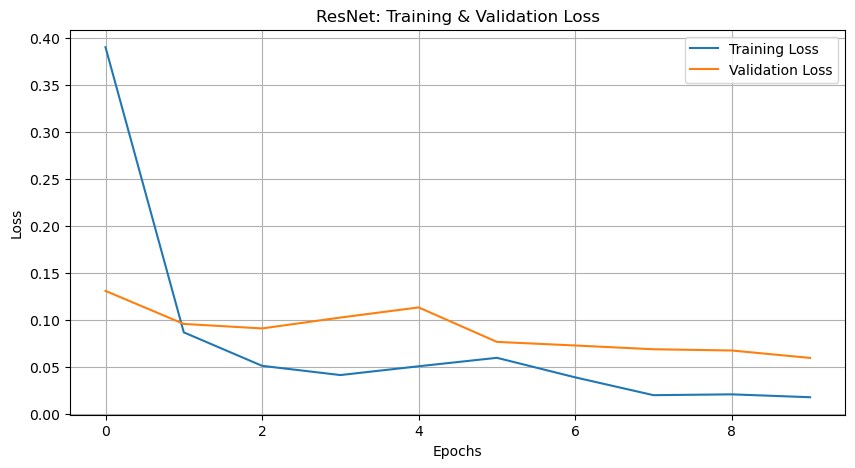

In [327]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_resnet, label='Training Loss')
plt.plot(test_losses_resnet, label='Validation Loss')
plt.title('ResNet: Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [328]:
model_resnet.eval()
y_true, y_pred_resnet = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred_resnet.extend(preds.cpu().numpy())

print("ResNet50")
print("Accuracy:", accuracy_score(y_true, y_pred_resnet))
print("Precision (macro):", precision_score(y_true, y_pred_resnet, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred_resnet, average='macro'))
print("F1-score (macro):", f1_score(y_true, y_pred_resnet, average='macro'))

ResNet50
Accuracy: 0.9832142857142857
Precision (macro): 0.9833253986723974
Recall (macro): 0.9832575550598908
F1-score (macro): 0.983221181169627


submission файлы

In [331]:
model_mlp.eval()
y_pred_mlp = []
with torch.no_grad():
    for images in submission_loader:
        images = images[0].to(device)
        outputs = model_mlp(images)
        _, preds = torch.max(outputs, 1)
        y_pred_mlp.extend(preds.cpu().numpy())

submission_df_mlp = pd.DataFrame({"ImageId": range(1, len(y_pred_mlp)+1), "Label": y_pred_mlp})
submission_df_mlp.to_csv("submission_mlp.csv", index=False)

In [332]:
model_cnn.eval()
y_pred_cnn = []
with torch.no_grad():
    for images in submission_loader:
        images = images[0].to(device)
        outputs = model_cnn(images)
        _, preds = torch.max(outputs, 1)
        y_pred_cnn.extend(preds.cpu().numpy())

submission_df_cnn = pd.DataFrame({"ImageId": range(1, len(y_pred_cnn)+1), "Label": y_pred_cnn})
submission_df_cnn.to_csv("submission_cnn.csv", index=False)

In [333]:
model_resnet.eval()
y_pred_resnet = []
with torch.no_grad():
    for images in submission_loader:
        images = images[0].to(device)
        outputs = model_resnet(images)
        _, preds = torch.max(outputs, 1)
        y_pred_resnet.extend(preds.cpu().numpy())

submission_df_resnet = pd.DataFrame({"ImageId": range(1, len(y_pred_resnet)+1), "Label": y_pred_resnet})
submission_df_resnet.to_csv("submission_resnet.csv", index=False)

## Сравнение результатов нейросетевых моделей

In [329]:
models_nn = ["MLP", "CNN", "ResNet"]
y_preds_nn = [y_pred_mlp, y_pred_cnn, y_pred_resnet]

data_nn = []
for model, y_pred in zip(models_nn, y_preds_nn):
    row = {
        "Model": model,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='macro'),
        "Recall": recall_score(y_test, y_pred, average='macro'),
        "F1": f1_score(y_test, y_pred, average='macro'),
    }
    data_nn.append(row)

df_nn_metrics = pd.DataFrame(data_nn)
df_nn_metrics

,Model,Accuracy,Precision,Recall,F1
0,MLP,0.974405,0.974234,0.974256,0.974178
1,CNN,0.991548,0.991420,0.991455,0.991433
2,ResNet,0.983214,0.983325,0.983258,0.983221


# Общий вывод и сравнение результатов всех моделей

In [330]:
df_all = pd.concat([
    df_metrics[["Model", "Accuracy (best)", "Precision (best)", "Recall (best)", "F1 (best)"]]
        .rename(columns={
            "Accuracy (best)": "Accuracy",
            "Precision (best)": "Precision",
            "Recall (best)": "Recall",
            "F1 (best)": "F1"
        }),
    df_nn_metrics
], ignore_index=True)

df_all

,Model,Accuracy,Precision,Recall,F1
0,LogReg,0.920119,0.918986,0.919634,0.919226
1,SVM,0.979881,0.979795,0.979742,0.979758
2,kNN,0.968333,0.968560,0.968388,0.968306
3,RandomForest,0.963571,0.963514,0.963709,0.963583
4,CatBoost,0.965357,0.965354,0.965117,0.965213
5,MLP,0.974405,0.974234,0.974256,0.974178
6,CNN,0.991548,0.991420,0.991455,0.991433
7,ResNet,0.983214,0.983325,0.983258,0.983221


Итоговый вывод по результатам

По результатам анализа, сверточная нейронная сеть (CNN) является безусловным лидером для задачи распознавания цифр MNIST, достигнув наивысшей точности в 99.15%. 

Это подтверждает превосходство специализированных архитектур для работы с изображениями.
Среди классических методов наилучшую производительность продемонстрировал Метод опорных векторов (SVM) с точностью 97.99%. Он показал себя как мощная и конкурентоспособная альтернатива, почти превзойдя даже более сложную нейросетевую архитектуру ResNet50 (98.32%).

Таким образом, для достижения максимального качества наилучшим выбором является CNN.

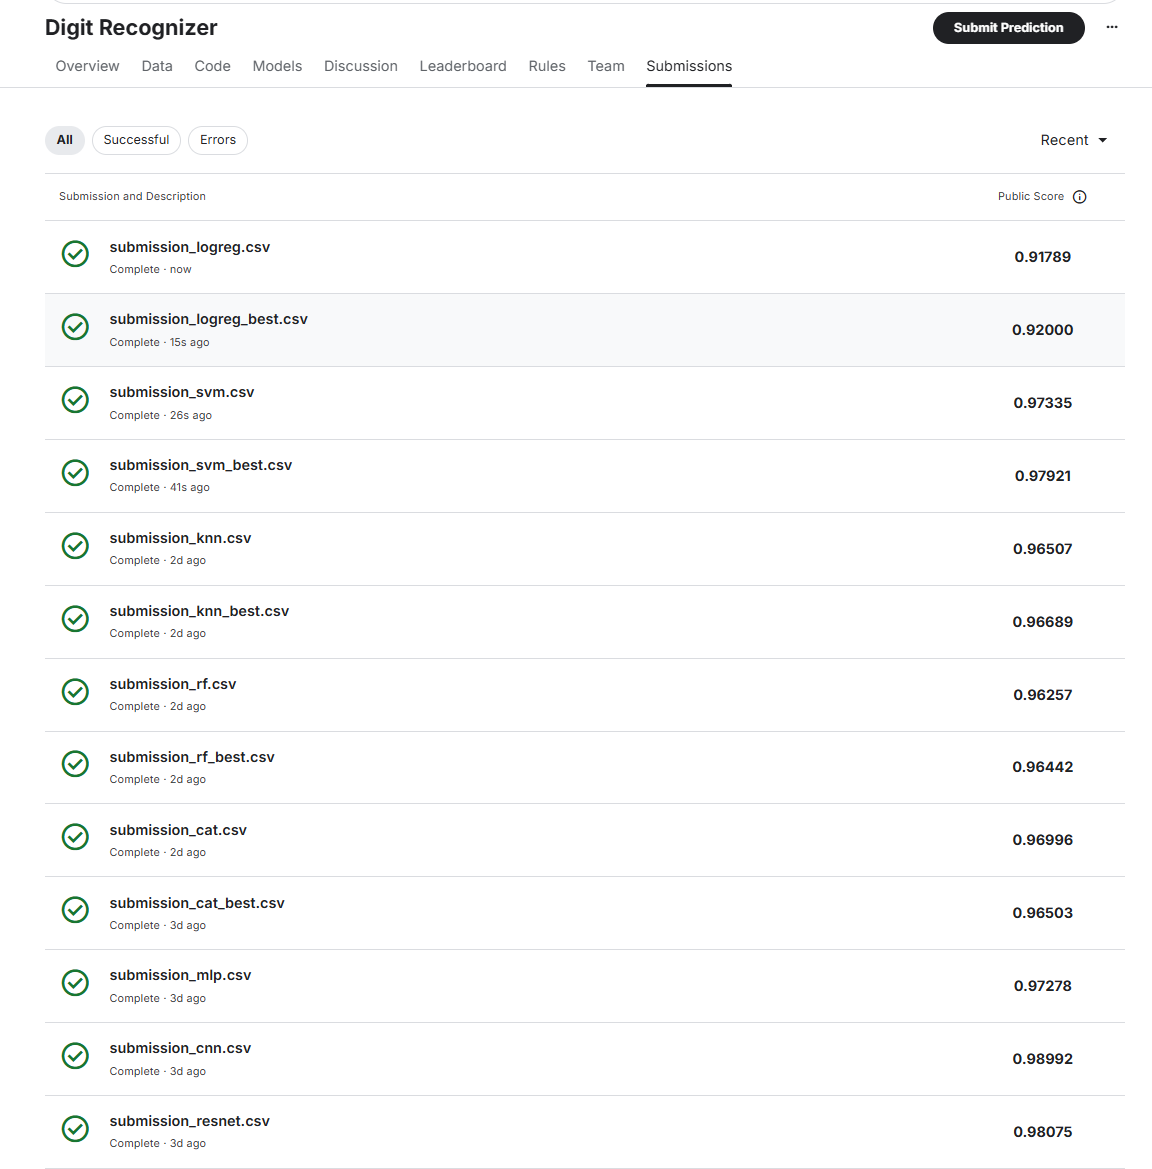


| Файл (Submission) | Оценка (Public Score) |
| :--- | :--- |
| submission_logreg.csv | 0.91789 |
| submission_logreg_best.csv | 0.92000 |
| submission_svm.csv | 0.97335 |
| submission_svm_best.csv | 0.97921 |
| submission_knn.csv | 0.96507 |
| submission_knn_best.csv | 0.96689 |
| submission_rf.csv | 0.96257 |
| submission_rf_best.csv | 0.96442 |
| submission_cat.csv | 0.96996 |
| submission_cat_best.csv | 0.96503 |
| submission_mlp.csv | 0.97278 |
| **submission_cnn.csv** | **0.98992** |
| submission_resnet.csv | 0.98075 |

### Вывод

Результаты наглядно демонстрируют эволюцию методов машинного обучения в задачах компьютерного зрения:

1.  **Линейные модели (LogReg):** Показывают самый низкий результат (~92%), так как плохо улавливают сложные нелинейные зависимости между пикселями.
2.  **Классический ML (KNN, RF, CatBoost):** Справляются значительно лучше (~96-97%).
3.  **SVM (Метод опорных векторов):** Показал впечатляющий результат для "классики" (~97.9%), почти догнав простые нейросети.
4.  **Нейросети (Deep Learning):**
    *   **CNN (Сверточная сеть):** Ожидаемый победитель с результатом **~99%**. Сверточные сети идеально подходят для обработки изображений.
    *   **ResNet:** Показал результат хуже, чем простая CNN (0.98). Для простых черно-белых картинок размером 28x28 пикселей архитектура ResNet часто бывает избыточной и может страдать от переобучения, если не настроена идеально.